<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/trim-filter-messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 过滤与裁剪对话消息（Filtering and Trimming Messages）

## 回顾

到目前为止，我们已经进一步理解了以下内容：

- 如何自定义图状态（Graph State）的数据模式（Schema）
- 如何定义自定义的状态归并器（State Reducers）
- 如何在一个项目中使用多种图状态 Schema

## 目标

接下来，我们将在 LangGraph 中把这些概念用于实际模型调用。

在后续章节里，我们会逐步构建一个支持长期记忆的聊天机器人。

因为机器人依赖消息来对话，我们先介绍在图状态中处理消息的几种高级方式：过滤（Filter）与裁剪（Trim）。

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

In [2]:
import os, getpass

# 小工具：若环境变量未设置，则在运行时提示手动输入并写入到进程环境变量
# 生产环境建议通过更安全的方式（如 .env、密钥管理服务、CI/CD 注入）设置

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# OpenAI API 密钥（用于 ChatOpenAI 调用）
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[调用追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)。

本笔记会将追踪数据记录到项目 `langchain-academy` 中。

In [3]:
# LangSmith 用于链路追踪与可视化分析
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
# 指定追踪项目名，便于区分不同实验/环境
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


## 将消息作为状态（Messages as State）

首先，我们先定义一些对话消息。

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# 定义一组对话消息（先是 AI，再是人类），用于后续示例
messages = [AIMessage(f"你之前说你在研究海洋哺乳动物，对吗？", name="Bot")]
messages.append(HumanMessage(f"是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance"))
# 以更易读的格式打印消息，便于调试与理解
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？


回顾一下：我们可以直接把这组消息传给聊天模型。

In [5]:
from langchain_openai import ChatOpenAI

# 初始化聊天模型；gpt-4o 仅为示例，可根据账号权限与成本选择其他模型
llm = ChatOpenAI(model="gpt-4o")

# 直接将完整消息历史传入模型（注意：长对话会推高 token 与延迟）
llm.invoke(messages)

AIMessage(content='除了鲸鱼，还有许多其他的海洋哺乳动物值得了解。其中包括：\n\n1. **海豚**：海豚是非常聪明的哺乳动物，以其复杂的社会行为和高水平的智力著称。种类很多，如瓶鼻海豚、虎鲸（也称杀人鲸，实际上是海豚的一种）等。\n\n2. **海豹**：海豹是鳍足类动物，生活在全球范围内的海洋中。常见的种类包括普通海豹、象海豹和北极环斑海豹等。\n\n3. **海狮**：海狮也是鳍足类动物，它们与海豹不同的是可以更灵活地在陆地上行走。加州海狮是最为知名的品种之一。\n\n4. **海象**：海象以其巨大的体型和长长的獠牙而闻名，主要生活在北极地区。\n\n5. **儒艮和海牛**：这些被称为“海牛”的大型草食性哺乳动物主要生活在温暖的沿海水域。它们被认为是美人鱼传说的起源。\n\n6. **北极熊**：虽然不总是被认为是海洋哺乳动物，但北极熊依赖海洋栖息地和海冰以获得食物。\n\n了解这些动物不仅能够帮助我们认识多样化的海洋生态系统，还有助于推动它们的保护和研究工作。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 339, 'prompt_tokens': 45, 'total_tokens': 384, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CEXOnnJySL61wZnbHpFl1kEnmq8HU', 'service_tier': Non

我们可以在一个使用 `MessagesState` 的简单图（Graph）里运行聊天模型。

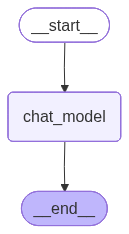

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# 定义一个图节点：接收状态中的所有消息，直接调用聊天模型
# 注意：此处未做任何过滤/裁剪，长对话会不断增长

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# 构建最简图：START -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化图结构
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼，研究海洋哺乳动物时还可以了解以下几类：

1. **海豚（Dolphins）**：海豚是非常聪明的海洋哺乳动物，属于齿鲸亚目，许多种类广泛分布于全球各大洋。

2. **鼠海豚（Porpoises）**：与海豚相似但体型较小，齿形为铲状，与海豚的锥形牙齿不同。

3. **海豹（Seals）**：海豹是鳍脚类动物之一，适应在陆地和海洋环境中生存。

4. **海狮（Sea Lions）和海象（Walrus）**：这些也是鳍脚类动物，海狮以其外露的耳廓与海豹区分开来，而海象有长长的獠牙。

5. **儒艮（Dugongs）和海牛（Manatees）**：这些被统称为海牛目动物，主要生活在浅水中，以海草为食。

6. **北极熊（Polar Bears）**：虽然严格来说属于陆生哺乳动物，但它们依赖海冰狩猎海豹，是重要的海洋食性动物。

7. **海獭（Sea Otters）**：海獭是食肉目动物，生活在北太平洋，主要以海胆、贝类等为食，对海洋生态系统有重要影响。

了解这些动物的生物学特性、生态角色和保护现状，可以帮助更全面地理解海洋生态系统。


## 归并器（Reducer）

在处理消息时，一个实际挑战是管理“长对话”。

如果不加控制，随着对话历史不断增长，模型每次都会接收越来越长的消息列表，导致令牌（token）消耗增大、延迟升高。

为了解决这个问题，我们有几种常用方法。

首先，回顾之前的技巧：使用 `RemoveMessage` 配合 `add_messages` 归并器来删除不需要的历史消息。

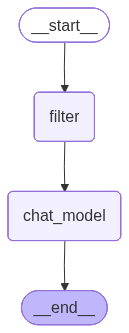

In [8]:
from langchain_core.messages import RemoveMessage

# 过滤节点：仅保留最近 2 条消息，删除更早的历史
# 使用 RemoveMessage + add_messages 归并器的组合语义

def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# 调用节点：将过滤后的消息传给模型

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# 构建图：START -> filter -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("你好。", name="Bot", id="1")]
messages.append(HumanMessage("你好。", name="Lance", id="2"))
messages.append(AIMessage("你之前说你在研究海洋哺乳动物，对吗？", name="Bot", id="3"))
messages.append(HumanMessage("是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者。

7. **北极熊（Polar Bears）**：尽管不是完全生活在海中，但它们经常依赖海冰来捕猎海豹，因此也被视作海洋哺乳动物的一员。

了解这些海洋哺乳动物有助于你对它们在生态系统中所扮演的角色和它们面临的保护问题有更全面的认识。


## 过滤消息（Filtering Messages）

如果你不需要或不想修改图状态本身，可以只对“传入聊天模型的消息列表”进行过滤。

例如，仅把最后一条消息传给模型：`llm.invoke(messages[-1:])`。

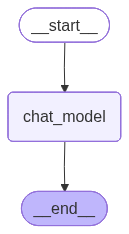

In [10]:
# 仅传入“最后一条消息”给模型，避免把整段历史都送入模型
# 注意：这种方式适用于上下文依赖较弱的问答；若强依赖上下文，请考虑裁剪（trim）而非简单过滤

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

接下来，我们把现有消息列表继续扩展：先加入上面的 LLM 回复，再追加一个追问。

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"再告诉我一些关于独角鲸的事吧！", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者

图状态中仍然保存着全部消息。

不过，从 LangSmith 的追踪可以看到：模型实际调用时只使用了最后一条消息。

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## 裁剪消息（Trim Messages）

另一种方式是按令牌数对历史进行“裁剪”（trim）：即通过 [`trim_messages`](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens) 限制用于本次回复的历史消息总令牌数。

- 过滤（filter）：只是事后挑选一部分消息传给模型；
- 裁剪（trim）：从头/尾等策略出发，严格限制可用的历史上下文所占令牌数。

下面演示如何使用 `trim_messages`。

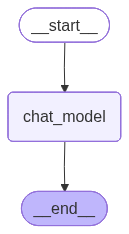

In [14]:
from langchain_core.messages import trim_messages

# 节点：对“历史消息”按令牌数进行裁剪，再调用模型
# - max_tokens：历史消息允许占用的最大 token 数
# - strategy：裁剪策略（"last" 表示优先保留靠后的消息）
# - token_counter：用于估算 token 数的模型或计数器
# - allow_partial：为 False 时，不会截断单条消息的一部分（保证每条消息的完整性）

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

最后，我们再通过 LangSmith 追踪看看本次模型调用的实际入参情况：

https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/d0a1a7a3-9644-4271-82cb-ccadc3ab6969?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=e3584c0f-6c78-4bbd-9178-ab793cdd89e4&peeked_trace=e3584c0f-6c78-4bbd-9178-ab793cdd89e4